In [2]:
import PinkBlack.io
from PinkBlack.trainer import Trainer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


import os, glob
import numpy as np
from sklearn.model_selection import train_test_split

from dataset.kernel_image_pair import KernelImagePair, default_augmentations, default_transforms
from network.sftmd import SFTMD, Predictor, Corrector

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [5]:
import numpy as np
import math
from torchvision.utils import make_grid
def tensor2img(tensor, out_type=np.uint8, min_max=(0, 1)):
    '''
    Converts a torch Tensor into an image Numpy array
    Input: 4D(B,(3/1),H,W), 3D(C,H,W), or 2D(H,W), any range, RGB channel order
    Output: 3D(H,W,C) or 2D(H,W), [0,255], np.uint8 (default)
    '''
    tensor = tensor.squeeze().float().cpu().clamp_(*min_max)  # clamp
    tensor = (tensor - min_max[0]) / (min_max[1] - min_max[0])  # to range [0,1]
    n_dim = tensor.dim()
    if n_dim == 4:
        n_img = len(tensor)
        img_np = make_grid(tensor, padding=0, nrow=1, normalize=False).numpy()
        img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    elif n_dim == 3:
        img_np = tensor.numpy()
        img_np = np.transpose(img_np[[2, 1, 0], :, :], (1, 2, 0))  # HWC, BGR
    elif n_dim == 2:
        img_np = tensor.numpy()
    else:
        raise TypeError(
            'Only support 4D, 3D and 2D tensor. But received with dimension: {:d}'.format(n_dim))
    if out_type == np.uint8:
        img_np = (img_np * 255.0).round()
        # Important. Unlike matlab, numpy.unit8() WILL NOT round by default.
    return img_np.astype(out_type)

In [6]:
def show_results(sr, ds):
    sr = tensor2img(sr)
    lr = Image.fromarray(tensor2img(ds['LR']))
    hr = Image.fromarray(tensor2img(ds['HR']))
#     display(lr)
#     display(lr.resize((lr.size[0]*scale, lr.size[1]*scale), Image.BICUBIC))
#     display(Image.fromarray(sr))
#     display(hr)
    fig = plt.figure(figsize=[6.4*6, 4.8*4])

    fig.add_subplot(3,12,26)
    plt.imshow(lr)
    fig.add_subplot(142)
    plt.imshow(lr.resize((lr.size[0]*scale, lr.size[1]*scale), Image.BICUBIC))
    fig.add_subplot(143)
    plt.imshow(sr)
    fig.add_subplot(144)
    plt.imshow(hr)

In [22]:
def metric(output, bd):
    with torch.no_grad():
        sr = output
        hr = bd['HR']
        diff = sr - hr
        shave = 4 + 10
        valid = diff[..., shave:-shave, shave:-shave]
        mse = valid.pow(2).mean()
        return -10 * torch.log10(mse)

In [7]:
train_imgs = glob.glob("../data/DIV2K/DIV2K_train_HR/**/*.png", recursive=True)
test_imgs = glob.glob("../data/testing_datasets/Set5/*.png", recursive=True)
train_kernel = "kernels/train/kernel_scale4_iso_dim10.pth"
test_kernel = "kernels/test_2/kernel_scale4_iso_dim10.pth"
scale=4
batch_size=1

# test_imgs = glob.glob("../data/testing_datasets/Set5/**/*.png", recursive=True)
# test_imgs

In [15]:
train_dataset = KernelImagePair(imgs=train_imgs, 
                            kernel_pickle=train_kernel, scale=scale, 
                            augmentations=default_augmentations, transforms=default_transforms, 
                            seed=0, train=True)
test_dataset = KernelImagePair(imgs=test_imgs, 
                            kernel_pickle=test_kernel, scale=scale, 
                            augmentations=default_augmentations, transforms=default_transforms, 
                            seed=0, train=False)

In [9]:
dl = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

In [13]:
_sftmd = "ckpt/sftmd/191019_0_x4_cosine_res_every_20k_lr_1e-4_1e-7_no_gradclip_bs16_winit_default.pth"
_predictor = "ckpt/predictor/191020_0_x4_lr_1e-4_no_scheduler_no_gradclip_bs16.pth"
_corrector = "ckpt/corrector/191019_0_x4___191020_0_x4_191022.pth-23500"

In [14]:
sftmd = SFTMD(scale=scale).cuda()
sftmd.load_state_dict(torch.load(_sftmd))
sftmd.eval()
""

''

In [16]:
predictor = Predictor(train_dataset.pca).cuda()
predictor.load_state_dict(torch.load(_predictor))
predictor.eval()
""

''

In [17]:
corrector = Corrector().cuda()
corrector.load_state_dict(torch.load(_corrector))
corrector.eval()
""

''

# test Corrector

In [18]:
it = iter(dl)

In [20]:
with torch.no_grad():
    ds = next(it)
    print(ds['stddev'])
    for k, v in ds.items():
        if torch.is_tensor(v):
            ds[k] = v.cuda()

tensor([2.2855], dtype=torch.float64)


In [24]:
ds['k_reduced'].shape

torch.Size([1, 10])

In [23]:
kernels = []
srs = []
metrics = []

In [25]:
with torch.no_grad():
    k_reduced_gt = ds['k_reduced'][0]
    ds['k_reduced'] = predictor(ds, recon_kernel=False)
    kernels.append(ds['k_reduced'][0])
    for i in range(7):
        sr = sftmd(ds)
        ds['SR'] = sr
        ds['k_reduced'] = corrector(ds)
        srs.append(sr[0])
        metrics.append(metric(sr, ds).item())
        kernels.append(ds['k_reduced'][0])

In [26]:
pca = train_dataset.pca
kr_recons = []
for kr in kernels:
    kr_np = kr.cpu().numpy()
    kr_recons.append(pca.inverse_transform(kr_np).reshape(21, 21))

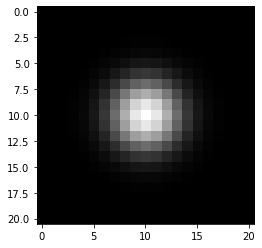

In [30]:
kr_gt_np = k_reduced_gt.cpu().numpy()
kr_gt_np_recon = pca.inverse_transform(kr_gt_np).reshape(21,21)
plt.imshow(kr_gt_np_recon, cmap="gray")
plt.show()

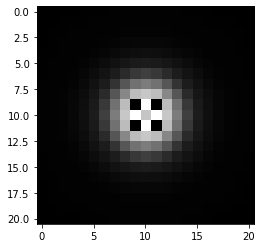

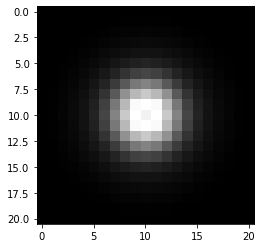

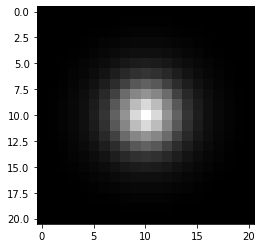

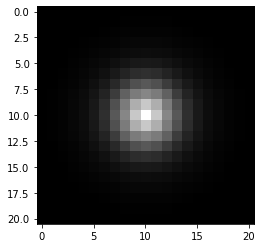

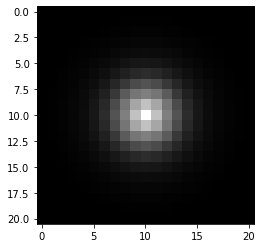

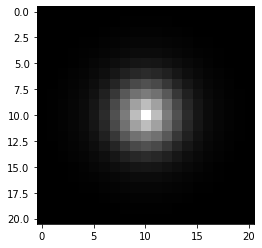

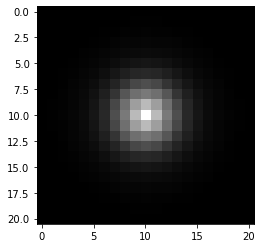

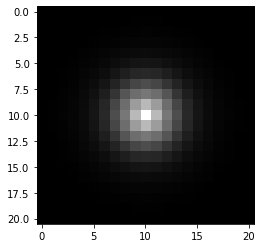

In [29]:
for kr_recon in kr_recons:
    plt.imshow(kr_recon, cmap="gray")
    plt.show()

In [11]:
with torch.no_grad():
    sr = net(ds)
    print(sr.shape)
show_results(sr, ds)

torch.Size([1, 3, 1068, 2040])


# Test predictor

In [83]:
import json
predictor = Predictor(train_dataset.pca).cuda()
predictor.load_state_dict(torch.load("ckpt/predictor/191020_0_x4_lr_1e-4_no_scheduler_no_gradclip_bs16.pth"))
predictor.eval()
json.load(open("ckpt/predictor/191020_0_x4_lr_1e-4_no_scheduler_no_gradclip_bs16.pth.config"))

{'max_train_metric': -8.017912577981849e-05,
 'max_val_metric': -2.4865979503374548e-05,
 'max_test_metric': -9.764961382643379e-06,
 'logdir': 'ckpt/predictor/191020_0_x4_lr_1e-4_no_scheduler_no_gradclip_bs16.pth_tb/',
 'timestamp': '20191020_230902',
 'clip_gradient_norm': False,
 'is_data_dict': True,
 'experiment_name': '191020_0_x4_lr_1e-4_no_scheduler_no_gradclip_bs16',
 'step': 104500,
 'train_loss': 8.017912577981849e-05,
 'train_metric': -8.017912577981849e-05,
 'val_loss': 2.4865979503374548e-05,
 'val_metric': -2.4865979503374548e-05,
 'test_loss': 9.764961382643379e-06,
 'test_metric': -9.764961382643379e-06,
 'set5_loss': 6.437659158109454e-06,
 'set5_metric': -6.437659158109454e-06,
 'urban100_loss': 1.1336605202814099e-05,
 'urban100_metric': -1.1336605202814099e-05,
 'max_set5_metric': 0.0,
 'max_urban100_metric': 0.0}

In [12]:
it = iter(dl)

In [13]:
ds = next(it)
print(ds['stddev'])
for k, v in ds.items():
    if torch.is_tensor(v):
        ds[k] = v.cuda()

tensor([1.8099], dtype=torch.float64)


In [14]:
with torch.no_grad():
    k_estimated = predictor(ds, recon_code=False)
# ds['k_save'] = ds['k']
# ds['k'] = k_estimated
# k_np = ds['k_save'].cpu().numpy().reshape(21, 21)
# k_estimated_np = ds['k'].cpu().numpy().reshape(21, 21)

In [54]:
kn = k_estimated.cpu().numpy()

In [55]:
kn

array([[  3.9513104 ,   2.5394523 ,  -4.195571  ,  18.93788   ,
          0.09772182, -10.879078  ,  -5.647569  ,   7.171652  ,
         -4.403939  ,  -2.3788943 ]], dtype=float32)

In [59]:
train_dataset.pca.components_.shape

(10, 441)

In [60]:
train_dataset.pca.mean_.shape

(441,)

In [64]:
cp_ = torch.tensor(train_dataset.pca.components_, dtype=torch.float32)
mn_ = torch.tensor(train_dataset.pca.mean_, dtype=torch.float32)


In [72]:
code = ds['k'].view(1, 441).cpu()

In [79]:
(code - mn_).shape

torch.Size([1, 441])

In [80]:
cp_.t()

torch.Size([10, 441])

In [82]:
ds['k_reduced']

tensor([[-1.0590e-01,  1.3265e-02, -3.1409e-02,  8.2115e-03,  1.8565e-03,
          2.0822e-03, -2.5221e-05,  2.2686e-04, -5.5042e-05,  2.4488e-05]],
       device='cuda:0')

In [81]:
torch.matmul(code - mn_, cp_.t())`

tensor([[-1.0590e-01,  1.3265e-02, -3.1409e-02,  8.2114e-03,  1.8565e-03,
          2.0822e-03, -2.5222e-05,  2.2687e-04, -5.5040e-05,  2.4486e-05]])

In [33]:
gt = train_dataset.k_reduced[0]

In [32]:
gt.shape

(441,)

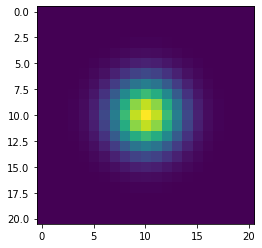

In [34]:
plt.imshow(train_dataset.pca.inverse_transform(gt).reshape(21,21))

-0.154433331614393

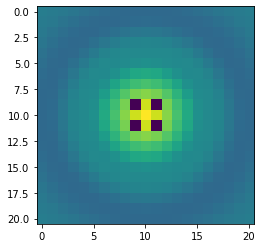

In [45]:
plt.imshow(train_dataset.pca.inverse_transform(kn).reshape(21,21))

In [49]:
rec_gt = train_dataset.pca.inverse_transform(gt).reshape(21,21)
rec_gt.sum()

1.000000000000001

In [52]:
rec_gt.max()

0.030469358134239413

In [53]:
rec_gt.min()

1.2661429815228167e-07

In [50]:
rec = train_dataset.pca.inverse_transform(kn).reshape(21,21)
rec.sum()

1.000000000000334

In [51]:
rec.min()

-4.076851501308736

In [15]:
k_estimated.sum()

tensor(5.1930, device='cuda:0')

In [44]:
k_estimated_np[9, 9]

9.543817e-06

0.004804317 0.0048941774 tensor([2.4905], device='cuda:0', dtype=torch.float64)


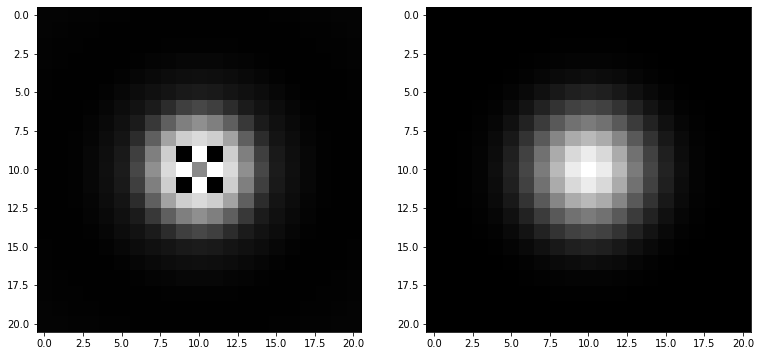

0.006287749 0.005422563 tensor([2.2855], device='cuda:0', dtype=torch.float64)


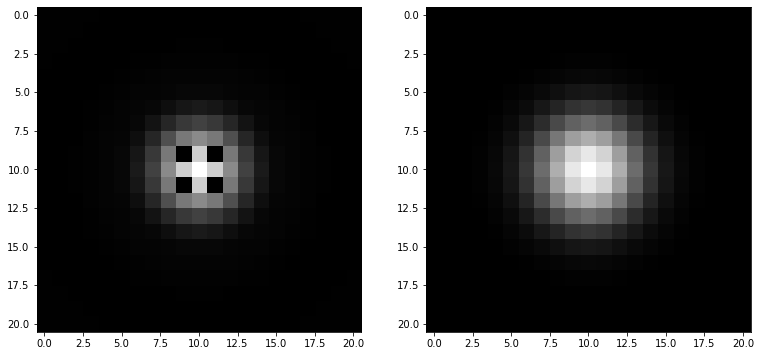

0.0045854 0.0048941774 tensor([2.4905], device='cuda:0', dtype=torch.float64)


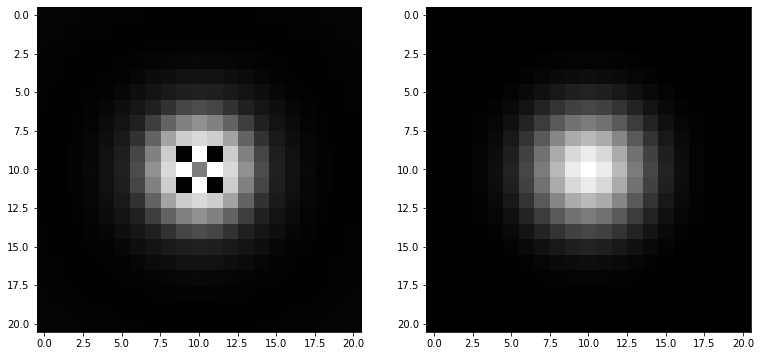

0.004521192 0.0048941774 tensor([2.4905], device='cuda:0', dtype=torch.float64)


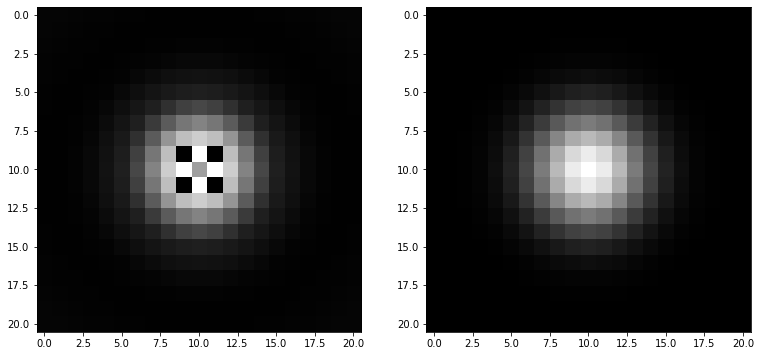

0.005612513 0.005422563 tensor([2.2855], device='cuda:0', dtype=torch.float64)


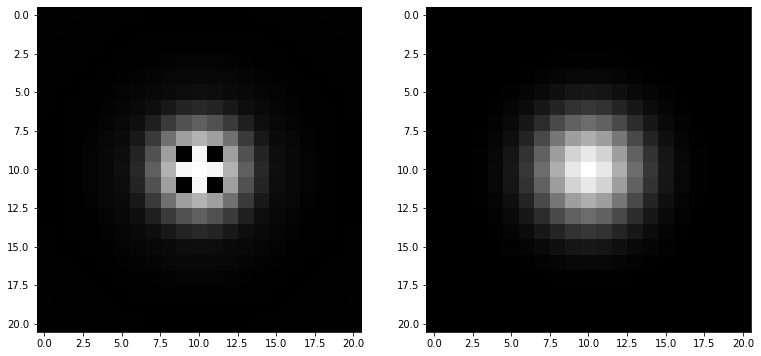

0.0042611477 0.0048941774 tensor([2.4905], device='cuda:0', dtype=torch.float64)


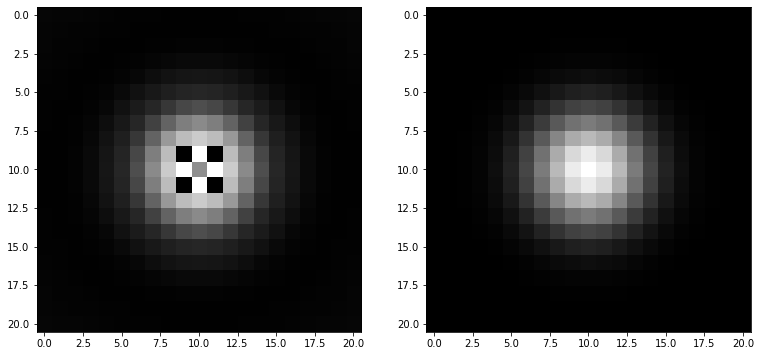

0.0047903797 0.00522466 tensor([2.3586], device='cuda:0', dtype=torch.float64)


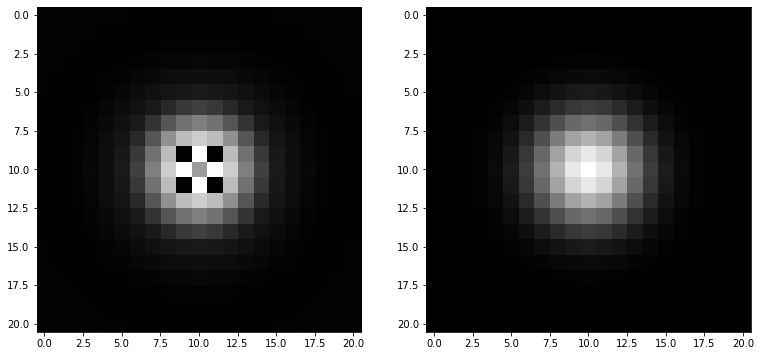

0.006377693 0.0068453085 tensor([1.8628], device='cuda:0', dtype=torch.float64)


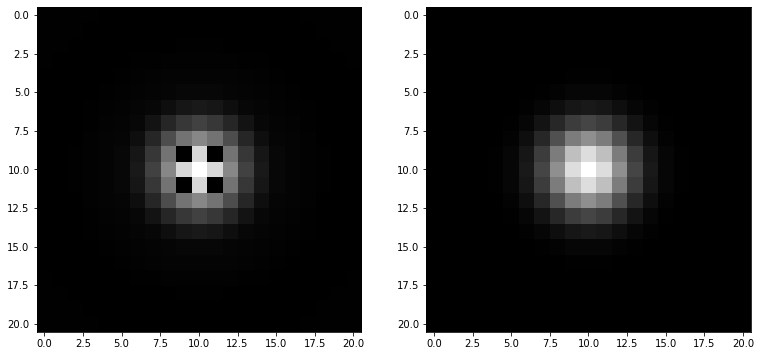

0.0044188295 0.005422563 tensor([2.2855], device='cuda:0', dtype=torch.float64)


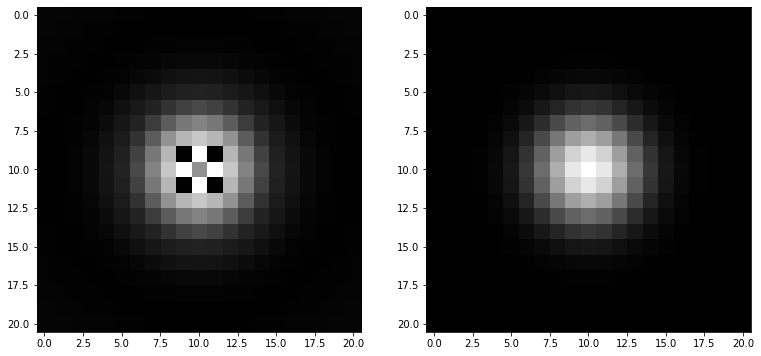

0.0041341064 0.0068453085 tensor([1.8628], device='cuda:0', dtype=torch.float64)


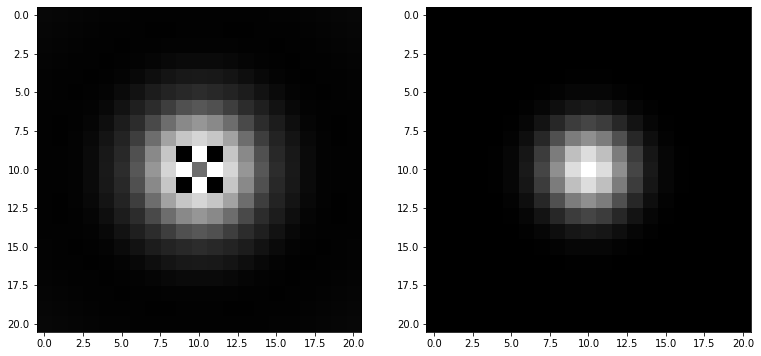

0.0051263194 0.005422563 tensor([2.2855], device='cuda:0', dtype=torch.float64)


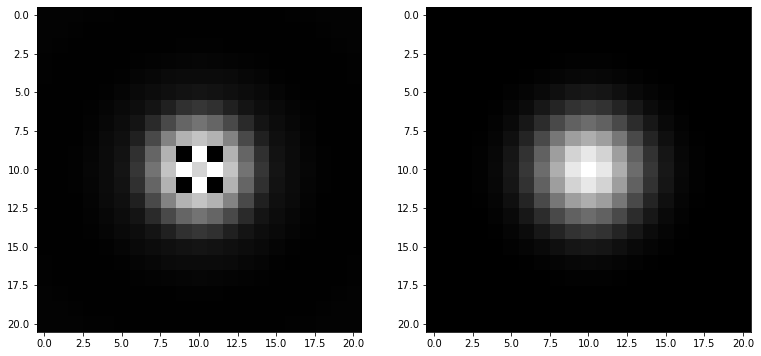

In [84]:
for i, ds in enumerate(dl):
    if i > 10:
        break
    for k, v in ds.items():
        if torch.is_tensor(v):
            ds[k] = v.cuda()
    with torch.no_grad():
        k_estimated = predictor(ds)
    ds['k_save'] = ds['k']
    ds['k'] = k_estimated
    k_np = ds['k_save'].cpu().numpy().reshape(21, 21)
    k_estimated_np = ds['k'].cpu().numpy().reshape(21, 21)
    
    print(np.std(k_estimated_np), np.std(k_np), ds['stddev'])
    
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.subplot(121)
    fig.imshow(k_estimated_np, cmap="gray")
    fig = plt.subplot(122)
    fig.imshow(k_np, cmap="gray")
    plt.show()

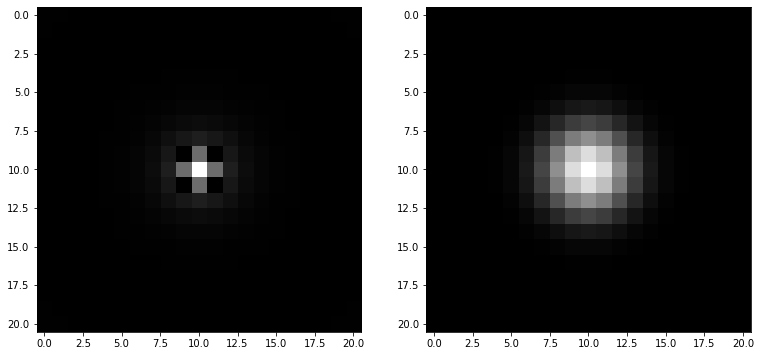

In [22]:
plt.figure(figsize=(12.8, 9.6))
fig = plt.subplot(121)
fig.imshow(k_estimated_np, cmap="gray")
fig = plt.subplot(122)
fig.imshow(k_np, cmap="gray")
plt.show()

In [ ]:
with torch.no_grad():
    sr = net(ds)
show_results(sr, ds)